## Building Chris's Protocol deconfliction

ToDos:
- Still need cycling
- Trying to collect data on random, round robin, and backpressure to do some comparison w/ auction
    - Get data collection going, and data analysis
    - Get some better scenarios to test with
    - Read Chris's experimental protocol and replicate
    - Execute out and check


In [18]:
from helpers import *
from scipy.stats import norm, poisson

In [19]:
class Agent():
    
    def __init__(self, origin, dest, var_cost, depart_t = 0, operator = None):
        
        """
        Initialize an Agent navigating the environment
        
        Input:
            origin: Hex, initial location
            dest: Hex, destination location
            var_cost: double, variable cost of operation
            depart_t: integer, time of departure
        Returns:
        
        """

        self._loc = -1   # -1 means grounded trying to enter air, 0 means arrived and down
        self._var_cost = var_cost

        # requested locations, payment costs and waiting costs
        self._steps = hex_linedraw(origin, dest)
        self._index = 0
        self._pay_costs = 0
        self._wait_costs = 0
        
        self._origin = origin
        self._dest = dest
        
        # departure and arrival times
        self._depart_t = depart_t
        self._schedule_t = depart_t + len(self._steps)
        self._arrival_t = None
        
        self._id = uuid.uuid4()
        self._operator = operator
        
    @property
    def bid(self):
        """
        Send out bid of (loc, price, id)
        Returns:
            out: tuple of (loc, price, id)
        """
        if self._index >= len(self._steps): # if you're done
            # self._loc = 0  # return no bid, and set arrival flag
            return (None, -1, self._id)  
        
        # check that requested location is right next to current
        assert self._loc == -1 or hex_distance(self._steps[self._index], self._loc) == 1
        
        return (self._steps[self._index], self._var_cost, self._id)
    
    @property
    def loc(self):
        """
        Return current location
        Returns:
            out: Hex of location
        """
        return self._loc
    
    @property
    def dest(self):
        """
        Return destination
        Returns:
            out: Hex of location
        """
        return self._dest
    
    @property
    def operator(self):
        """
        Return operator
        Returns:
            out: operator
        """
        return self._operator

    @property
    def finished(self):
        """
        Returns if agent has reached the destination
        Returns:
            out: bool
        """
        return self._loc == self._dest
    
    @property
    def costs(self):
        """
        Return costs incurred by agent so far
        This is essentially the extra costs incurred on top of costs from operatin w/o anyone else
        Returns:
            out: tuple of (pay_costs, wait_costs)
        """
        return (self._pay_costs, self._wait_costs)
    
    def move(self, command):
        """
        Move the bot
        Inputs:
            command: tuple of (next_loc, bid)
        Outputs:
            out: boolean to indicate at goal already
        """
        if self._index >= len(self._steps): return True  # if you're at the goal already
        
        next_loc, bid = command
        # if command is None, not cleared to move and you eat the variable cost
        if next_loc == None:
            self._wait_costs += self._var_cost
            return False
        
        # else move
        assert next_loc == self._steps[self._index]
        self._index += 1
        # del self._steps[0]
        self._loc = next_loc
        
        # pay the bid price
        self._pay_costs += bid
        return False

In [20]:
class Grid():
    """
    Contains the environment, the auctioneer
    
    Grid is small grid of 6 hexagons surrounding 7th center (q, r, s)
    
    
        (0, -1, 1)   (1, -1, 0)
    (-1, 0, 1)  (0,0,0)  (1, 0, -1)
        (-1, 1, 0)   (0, 1, -1)
    """
    
    
    def __init__(self, radius=1):
        """
        Creates Grid object
        
        Inputs:
            agents: list, agents in the environment

        """
        self._revenue = 0
        
        self.coords = create_hex_grid(radius)
        self.coords_l = list(self.coords)
        # if you want to do capacities, make a dictionary with {hex: capacity}
        
        # track the number of rounds an agent has been waiting {agent id: rounds waited}
        self._roundrobin = {}
        
        # track type of prioritization - default random
        # can be [random, roundrobin, backpressure]
        self._priority = "random"
        
        self.num_conflicts = 0
        self.radius = radius
        
    @property
    def revenue(self):
        """
        Returns current revenue of grid
        Returns:
            out: integer
        """
        return self._revenue
    
    @property
    def priority(self):
        return self._priority
    
    def set_priority(self, method):
        """
        Set the prioritization method
        Inputs:
            method: string of type of prioritization
        """
        assert method in ["random", "roundrobin", "backpressure", "secondprice", "secondback"]
        self._priority = method
        
    def step_sim(self, locations, bids):
        """
        Step through one step of Chris's protocol - this handles cycles on until hold/motion (lines 4 to 24 in Alg 1)
        Inputs:
            locations: {id : loc} all active agent locations (if you're trying to depart also active)
            bids: {id : (next_loc, price)} all active agent bids
        Returns:
            commands: dictionary of tuples {id : (next loc, winning price)} of size (# agents) (None, 0) means hold
        """
        # price = -1 means it's still undecided 
        # price = 0 means it's on hold
        # init commands
        commands = {_id: (None, -1) for (_id, (_, _)) in bids.items()}
        
        # build node graph - all departing flights are treated as coming from one massive ground node -1
        in_graph = {}   # inverse graph - points from inbound to outbound
        requests = {}   # dictionary of all locations requested and hwho's requesting
        for loc, (_id, (next_loc, price)) in zip(locations.values(), bids.items()):

            if price == -1: continue
            assert loc == -1 or loc in self.coords, "Coordinate does not exist in the grid"
            
            # build graph for cycle and backpressure
            if next_loc in in_graph.keys(): in_graph[next_loc].append(loc)
            else: in_graph[next_loc] = [loc]
            
            # buidl the request list - essentially all the bid info the agents gave
            # right now its {location: (id, stated value)}            
            if next_loc not in requests: requests[next_loc] = []
            requests[next_loc].append((_id, price))
            
            # add to round robin priority list
            if _id not in self._roundrobin: self._roundrobin[_id] = 0

        # print("graph\n", in_graph)
        # identify cycles (skipping for now)
        # print('requests', requests)
        cycle_ids = []
        for req in requests.keys():
            temp = self.find_cycles(in_graph, req)
            for loc in temp:
                count = 0
                for _id in locations.keys():
                    if _id not in cycle_ids and locations[_id] == loc and bids[_id][0] in temp and count < CAPACITY:
                        cycle_ids.append(_id)
                        count += 1
                        
        # print("cycling _id", cycle_ids)
        for _id in cycle_ids:
            commands[_id] = bids[_id]
        
        
        # calculate backpressure and sort - order is which sectors to deconflict first
            # NOTE: both backpressure and cycles requires building a graph at each step
        pressures = {req: self.calc_backpressure(in_graph, req) for req in requests.keys()}
        order = sorted(requests, key=lambda req: pressures[req], reverse=True)

        # handling every sector now
        for loc in order:
            asks = requests[loc]
            
            # print(asks)
            # assert 1 == 0
            
            # create a list of (index, price of bid)
            undecided = []
            decided = []
            for (_id, price) in asks:
                if commands[_id][1] == -1: undecided.append((_id, price))
                else: decided.append((_id, price))

            # resolve capacities
            # check if you still have capacity
            assert len(decided) <= CAPACITY, print(decided, "\n", locations, "\n", bids, "\n", commands, "\n", loc)
            if len(decided) < CAPACITY:
                
                # if you still have capacity 
                if len(undecided) <= CAPACITY - len(decided):

                    # function for moving undecided into G (aka all go)
                    # the 4 line block is the key
                    # assert bids[i][0] == loc
                    for i in range(len(undecided)):
                        (win_i, price) = undecided.pop(i)
                        commands[win_i] = (bids[win_i][0], 0)   # append comamnd
                        self._revenue += 0
                        decided.append((win_i, price))
                        
                # if you don't have capacity and have to decide
                else: 
#                     print("contested", loc)
                    self.num_conflicts += 1
                    while CAPACITY > len(decided):
                        
                        #PRIORITIZATION METHODS - win returns id of winning agent
                        if self._priority == "roundrobin": 
                            win, win_id, price = self.roundrobin_prioritization(undecided)
                            undecided.pop(win)
                        elif self._priority == "backpressure": 
                            win, win_id, price = self.backpressure_prioritization(undecided, locations, in_graph)
                            undecided.pop(win)
                        elif self._priority == "secondprice" :
                            win, win_id, price = self.secondprice_prioritization(undecided)
                            undecided.pop(win)
                        elif self._priority == "secondback":
                            win, win_id, price, moves = self.secondback_prioritization(undecided, locations, in_graph, bids)
                            undecided.pop(win)
                        else: 
                            win, win_id, price = self.random_prioritization(undecided)   # PRIORITIZATION using random prioritization
                            undecided.pop(win)
                            
                        if self._priority == "secondback":
                            # print(commands)
                            for move_id, move_price in moves:
                                commands[move_id] = [bids[move_id][0], move_price]
                            # print(commands)
                            
                        else:
                            commands[win_id] = (bids[win_id][0], price)

                        self._revenue += price
                        decided.append((win_id, price))
                        # assert 1 == 0
                        
            # end dealing with the sector - mark undecided as hold
            for (_id, price) in undecided:
                commands[_id] = (None, 0)
                self._roundrobin[_id] += 1
                if locations[_id] in requests: requests[locations[_id]].append((_id, price))

        # print("locs", locations)
        # print("bids", bids)
        # print("comms", commands)
        return commands


    
    def random_prioritization(self, undecided, seed = None):
        """
        Random prioritization method by merged queue, flight
        Inputs:
            undecided: list of tuples (index, price) of undecided flights
            seed: RNG seeder
        Returns:
            high_index: integer of an index in undecided
            win_id: id of winning agent
            price: price the agent pays
        """
        if seed: rand = np.random.default_rng(seed)
        else: rand = np.random.default_rng()
        
        win = rand.integers(len(undecided))
        (win_id, price) = undecided[win]
                                                                             
        return win, win_id, price
    
    def roundrobin_prioritization(self, undecided):
        """
        Trying to set up round robin prioritization around the grid
        If tied, first instance in undecided gets to go
        Inputs:
            undecided: list of tuples (index, price) of undecided flights
        Returns:
            high_index: integer of an index in undecided
            win_id: id of winning agent
            price: price the agent pays
        """
        
        high_wait = 0
        high_index = 0
        
        # find the highest wait
        for i, (_id, price) in enumerate(undecided):
            if self._roundrobin[_id] > high_wait:
                high_wait = self._roundrobin[_id]
                high_index = i
        
        # set highest wait to 0, b/c they're getting to move
        self._roundrobin[undecided[high_index][0]] = 0
        
        (win_id, price) = undecided[high_index]
                                                                             
        return high_index, win_id, price
        
        
    def backpressure_prioritization(self, undecided, locations, graph):
        """
        Using backpressure to resolve conflicts
        Inputs:
            undecided: list of tuples (_id, price) of undecided flights
            locations: {id:Hex} dictionary of all locations of agents
            graph: dictionary of Hex {inbound sector: [outbound sectors]}
        Returns:
            high_index: integer of current flights following
        """
        
        high_press = 0
        high_index = 0
        
        # find the highest backpressure
        for i, (_id, price) in enumerate(undecided):
            back_press = self.calc_backpressure(graph, locations[_id])
            
            if back_press > high_press:
                high_press = back_press
                high_index = i
       
        (win_id, price) = undecided[high_index]
                                                                             
        return high_index, win_id, price
    
    
    def secondprice_prioritization(self, undecided):
        """
        Sealed second price auction for locations - single square bid
    
        Inputs:
            requests: dictionary of (loc, (agent_id, bid)) to resolve
            num_agents: number of agents bidding
        
        Returns:
            output: list of tuples (next loc, winning bid) of size (# agents)
        """
        
        # get high bid
        high_index, winner = max(enumerate(undecided), key=lambda x:x[1][1])
        # print(undecided)
        
        # get price of second bid
        new = set(undecided)
        new.remove(winner)
    
        if not new: price = 0
        else: price = max(new, key=lambda x: x[1])[1]
    
        # self._revenue += price
        
        # print(high_index, winner, price)
        
        return high_index, winner[0], price
        
    def secondback_prioritization(self, undecided, locations, graph, bids):
        """
        Inputs:
            undecided: list of tuples (_id, price) of undecided flights
            locations: {id:Hex} dictionary of all locations of agents
            graph: dictionary of Hex {inbound sector: [outbound sectors]}
            bids: {id : (next_loc, price)} all active agent bids
        Outputs:
            
        """
        
        # calculate sum total value on every chain
        # create inverted locations dictionary - should be one to one IF capacity = 1
        assert CAPACITY <= 1, "Change this entire setup"
        invlocations = {v: k for k, v in locations.items()}
        # for every undecided branch
            # recursive helper function - input of undecided, graph - append that node's value to
        chains = [] # store chains
        for (_id, _) in undecided:
            chains.extend(self.secondback_helper(locations, invlocations, graph, bids, _id))

        # create the full total price
        for chain in chains:
            chain["total"] = sum(chain["price"])

        
        # the second price part similar to secondprice method
        chains = sorted(chains, key = lambda c: c["total"], reverse=True)
        # print(chains)
        winner = chains[0]
        # price = chains[1]["total"]

        # find second highest chain without intersection of winner
        winset = set(winner["chain"])
        index = 1
        price = 0
        while index < len(chains):
            intersection = [x for x in chains[index]["chain"] if x in winset]
            if len(intersection) == 0:
                price = chains[index]["total"]
                index = len(chains)
            index += 1

        high_index = None
        for j, (_id, _) in enumerate(undecided):
            if not high_index and _id == winner["chain"][-1]:
                high_index = j

        # print(chains)
        # print(winner, high_index)
        # print(price)

        # put out the commands for each agent
        commands = []
        for _id, bid in zip(winner["chain"], winner["price"]):
            if winner["total"] == 0:
                cost = 0
            else:
                cost = float(bid / winner["total"]) * price

            commands.append((_id, cost))
        
        # print(high_index, winner["chain"][-1], price, commands)

        return high_index, winner["chain"][-1], price, commands

        # clear the conflicts that have been resolved
            # this could be done by making sure all the commands are logged, then
            # the backpressure sort will enforce decided category
        
        # output commands - list the winners and the price paid, using proportional 

    
    def secondback_helper(self, locations, invlocations, graph, bids, _id):
        """
        Assume for now that it's just one transition every time - can break this problem later

        Recursive function that calculates a backpressure chain. 

        Outputs: 
            chains: an [] of dictionaries {chain: [], price: int}
        
        Return a []
        """
        
        # take in an _id
        
        in_loc = locations[_id]
        # print("helper", _id, in_loc)
        # base case - there's no inbound to this id, so no entry in graph
        if in_loc == -1 or in_loc not in graph:
            return [{"chain": [_id], "price": [bids[_id][1]]}]
        
        # run the function on outbound locations from graph, being careful of -1
        # get # get the location from locations - inverted lookup location from locations - inverted lookup
            # duplicate a query for every outbound sector listed
        chains = []
        for out_loc in graph[in_loc]:
            # dealing with the -1 case - if the next one is a grounded agent build the id and chain like base case
            out_id = None
            if out_loc == -1:

                for test_id, hex in locations.items():
                    if not out_id and hex == -1 and bids[test_id][0] == in_loc:
                        out_id = test_id
                
                # print("-1", out_id)

                chain_add = [{"chain": [out_id], "price": [bids[out_id][1]]}]

            # recursive call - otherwise append the out_id and chain value by the rest of the chain
            else:   
                out_id = invlocations[out_loc]
                chain_add = self.secondback_helper(locations, invlocations, graph, bids, out_id)
                       
            chains += chain_add
        
        
        # look up price and sum to every element of [chain, chain, ....] returned from above
            # where chain is {chain: [_ids], price: int}
        
        # add yourself to the chain
        for chain in chains:
            chain["chain"].append(_id)
            chain["price"].append(bids[_id][1])
        
        # return that array of chains
        return chains
    
    def find_cycles(self, graph, request, incoming = []):
        """
        Recursive function that finds the cycles active 
        """
        # if the request isn' in the graph, or all elements in [outgoing] are takeoff requests (-1)
        # or the recursion is too deep, there is no cycle and return []
        if request in graph.keys():
            new_ag = True
            for req in graph[request]:
                if req != -1:
                    new_ag = False
        
            if new_ag or len(incoming) > 50:
                return []
        else:
            return []
            
        # if request not in graph.keys() or graph[request][0] == -1 or len(incoming) > 50:
            # return []
  
        # cycle detection, you've found yourself in your own incoming chain
        if request in incoming:
            # print("req", request)
            # print("incoming", incoming)
            return incoming
        
        # recursive call, if pressures is anything it'll return the cycle
        pressures = []
        incoming.append(request)
        for req in graph[request]:
            pressures += self.find_cycles(graph, req, incoming)
        
        incoming.pop()
        return pressures
    
    
    def calc_backpressure(self, graph, request, depth = 0):
        """
        Calculate backpressure recursively, by starting from conflicted sectors
        and following inbound flights
        Inputs:
            graph: dictionary of Hex {inbound sector: [outbound sectors]}
            request: Hex of inbound sector to calculate backpressure from
            incoming: runnign record of 
            //depth: max depth of recursion
        Returns:
            out: integer of current flights following
        """
        # if the request isn' in the graph, or all elements in [outgoing] are takeoff requests (-1)
        # or the recursion is too deep, there is no cycle and return 0
        
        if request in graph.keys():
            new_ag = True
            for req in graph[request]:
                if req != -1:
                    new_ag = False
            
            if new_ag or depth > 50:
                return 0
        else:
            return 0

        # recursion to catch the rest of the pressures
        pressures = [self.calc_backpressure(graph, req, depth + 1) for req in graph[request]]
        return max(pressures) + 1
        

In [21]:
def create_random(num_agents = 1, radius = 1, iters = 10, seed = None, operator_flag = False):
    """
    Creates a grid, list of agents, and the schedule in which they deploy
    Inputs:
        radius: size of grid
        iters: iterations planned
        seed: seed for random number generator
    Outputs: (grid, agents, schedule)
        grid: the map we're operating on
        agents: list of all agents that will join the system during the sim
        schedule: time at which agents depart and join system
    """
    rand = np.random.default_rng(seed)
    grid = Grid(radius)

    # Agents get random OD and random departure time (arrival time judged by steps to there)
    # create radius # of agents, store schedule of when agents go to active list
    agents = []
    schedule = {}
    for _ in range(num_agents):
        
        
        OD = rand.integers(0, len(grid.coords_l), size=2)
        init_time = rand.integers(0, iters - radius)
        var_cost = rand.integers(1, 10)
        
#         print(grid.coords_l[OD[0]], grid.coords_l[OD[1]], init_time)
        operator = None
        if operator_flag:
            operator = rand.integers(1, 4)


        ag = Agent(grid.coords_l[OD[0]], grid.coords_l[OD[1]], var_cost, depart_t = init_time, operator = operator)
        agents.append(ag)
        
        if init_time in schedule.keys(): schedule[init_time].append(ag)
        else: schedule[init_time] = [ag]
        
        # store and release from active_agents list
        # have grid process and understand bids - will need wait times and queuing data stored w/ agents
    
    return grid, agents, schedule

    
create_random(num_agents = 3, radius = 3, iters = 10)

(<__main__.Grid at 0x17fbcbd90>,
 {2: [<__main__.Agent at 0x17fbcba90>],
  1: [<__main__.Agent at 0x17fbcba30>],
  4: [<__main__.Agent at 0x17fbcb910>]})

In [22]:
def create_bimodal(num_agents = 62, radius = 1, time = 50, seed = None, operator_flag=False):
    """
    
    """
    rand = np.random.default_rng(seed)
    grid = Grid(radius)
    
    weights_loc = rand.random(len(grid.coords_l))
    weights_loc = weights_loc / np.sum(weights_loc)
    
    x = np.linspace(0, time)
    weights_t = norm.pdf(x, 40, 5) + norm.pdf(x, 20, 8)
    weights_t = weights_t / np.sum(weights_t)
    
    agents = []
    schedule = {}
    for i in range(num_agents):
        
        OD = rand.choice(len(grid.coords_l), size = 2, replace = False, p = weights_loc)
        init_time = rand.choice(time, p = weights_t)
        var_cost = rand.integers(1, 10)

        operator = None
        if operator_flag:
            operator = i % 3 + 1

#         print(grid.coords_l[OD[0]], grid.coords_l[OD[1]], init_time)
        ag = Agent(grid.coords_l[OD[0]], grid.coords_l[OD[1]], var_cost, init_time, operator=operator)
        agents.append(ag)
        
        if init_time in schedule.keys(): schedule[init_time].append(ag)
        else: schedule[init_time] = [ag]
        
        # store and release from active_agents list
        # have grid process and understand bids - will need wait times and queuing data stored w/ agents
    
    return grid, agents, schedule

# create_bimodal(radius = 6)

In [23]:
#1
# (-r, r, 0), (-r, r-1, 1), ... (-r, r-n, n) => (r, -r, 0), (r, -r+1, -1), ... (r, -r+n, -n)

#2
# (0, r, -r), (1, r-1, -r), ... (n, r-n, -r) => (0, -r, r), (-1, -r+1, r), ... (-n, -r+n, r)

def create_crossing(num_agents = [50, 50], radius = 7, time = 50, points = 3, seed = None):
    """
    Create a crossing setup, where two operators are crossing over. Encode number of agents in size
    """
    # set up grid
    rand = np.random.default_rng(seed)
    grid = Grid(radius)
    
    assert points <= radius

    # set up time of departure
    x = np.linspace(0, time)
    weights_t = norm.pdf(x, 40, 5) + norm.pdf(x, 20, 8)
    weights_t = weights_t / np.sum(weights_t)

    # set up all origin and destination points
    op1 = [[], []]
    op2 = [[], []]
    for i in range(points):
        op1[0].append(Hex(-radius, radius - i, i))
        op1[1].append(Hex(radius, -radius + i, -i))

        op2[0].append(Hex(i, radius-i, -radius))
        op2[1].append(Hex(-i, -radius+i, radius))

    ops = [op1, op2]

    # iterate for the two operators
    agents = []
    schedule = {}
    for i, num in enumerate(num_agents):

        locs = ops[i]
        for _ in range(num):

            origin = rand.choice(len(locs[0]))
            departure = rand.choice(len(locs[1]))

            init_time = rand.choice(time, p = weights_t)
            var_cost = rand.integers(1, 10)


            operator = i+1

            assert locs[0][origin] in grid.coords and locs[1][departure] in grid.coords
    #         print(grid.coords_l[OD[0]], grid.coords_l[OD[1]], init_time)
            ag = Agent(locs[0][origin], locs[1][departure], var_cost, init_time, operator=operator)
            agents.append(ag)
            
            if init_time in schedule.keys(): schedule[init_time].append(ag)
            else: schedule[init_time] = [ag]

    return grid, agents, schedule

# create_crossing(num_agents = [40,60], radius = 7, time = 50, points = 4)

In [24]:
def create_crossing_2(num_agents = [50, 50, 50], radius = 7, time = 50, points = 3, seed = None):
    """
    Create a crossing setup, where two operators are crossing over. Encode number of agents in size
    """
    # set up grid
    rand = np.random.default_rng(seed)
    grid = Grid(radius)
    
    assert points <= radius

    # set up time of departure
    x = np.linspace(0, time)
    weights_t = norm.pdf(x, 40, 5) + norm.pdf(x, 20, 8)
    weights_t = weights_t / np.sum(weights_t)

    # set up all origin and destination points
    op1 = [[], []]
    op2 = [[], []]
    op3 = [[], []]
    for i in range(points):
        op1[0].append(Hex(-radius, radius - i, i))
        op1[1].append(Hex(radius, -radius + i, -i))

        # op2[0].append(Hex(i, radius-i, -radius))
        # op2[1].append(Hex(-i, -radius+i, radius))
        
        op2[0].append(Hex(-i, radius, -radius+i))
        op2[1].append(Hex(i, -radius, radius-i))

        op3[0].append(Hex(radius-i, i, -radius))
        op3[1].append(Hex(-radius+i, -i, radius))

    ops = [op1, op2, op3]

    # iterate for the two operators
    agents = []
    schedule = {}
    for i, num in enumerate(num_agents):

        locs = ops[i]
        for _ in range(num):

            origin = rand.choice(len(locs[0]))
            departure = rand.choice(len(locs[1]))

            init_time = rand.choice(time, p = weights_t)
            var_cost = rand.integers(1, 10)


            operator = i+1

            assert locs[0][origin] in grid.coords and locs[1][departure] in grid.coords
    #         print(grid.coords_l[OD[0]], grid.coords_l[OD[1]], init_time)
            ag = Agent(locs[0][origin], locs[1][departure], var_cost, init_time, operator=operator)
            agents.append(ag)
            
            if init_time in schedule.keys(): schedule[init_time].append(ag)
            else: schedule[init_time] = [ag]

    return grid, agents, schedule

In [25]:
def create_hubspoke(num_agents = [50, 50, 50], radius = 7, seed = None):
    """
    Create a hub and spoke scenario, with 3 operators each owning two positions
    Poisson distribution of launch? - mean 2
    """
    # set up grid
    rand = np.random.default_rng(seed)
    grid = Grid(radius)

    # hubs1 = [Hex(radius, -radius, 0), Hex(radius, 0, -radius)]
    # hubs2 = [Hex(0, radius, -radius), Hex(-radius, radius, 0)]
    # hubs3 = [Hex(-radius, 0, radius), Hex(0, -radius, radius)]

    # hubs = [hubs1, hubs2, hubs3]
    
    hubs = [Hex(radius, -radius, 0), Hex(radius, 0, -radius), Hex(0, radius, -radius), Hex(-radius, radius, 0), Hex(-radius, 0, radius), Hex(0, -radius, radius)]

    agents = []
    schedule = {}
    for i, num in enumerate(num_agents):

        t = 0
        origins = hubs[i]
        for _ in range(num):

            # org = rand.choice(len(origins))
            org = 0
            dest = rand.choice(len(grid.coords_l))

            t += poisson.rvs(mu=2)

            init_time = t
            var_cost = rand.integers(1, 10)
            operator = i+1

            # assert locs[0][origin] in grid.coords and locs[1][departure] in grid.coords
    #         print(grid.coords_l[OD[0]], grid.coords_l[OD[1]], init_time)
            ag = Agent(origins, grid.coords_l[dest], var_cost, init_time, operator=operator)
            agents.append(ag)
            
            if init_time in schedule.keys(): schedule[init_time].append(ag)
            else: schedule[init_time] = [ag]

    return grid, agents, schedule


In [26]:
def create_connected(radius = 1, iters = 10, seed = None):
    """
    Creates a grid, list of agents, and the schedule in which they deploy
    This setup is two lines of agents all trying to go to (0,0,0)
    Inputs:
        radius: int, size of grid
        iters: int, iterations planned
        seed: int, seed for random number generator
    Outputs: (grid, agents, schedule)
        grid: Grid, the map we're operating on
        agents: list of Agents, all agents that will join the system during the sim
        schedule: dictionary of {time: [Agents]} times at which agents depart and join system
    """
    assert radius >= 3
    
    rand = np.random.default_rng(seed)
    
    grid = Grid(radius)

    # Agents get random OD and random departure time (arrival time judged by steps to there)
    # create radius # of agents, store schedule of when agents go to active list
    agents = []
    schedule = {}
    for i in range(1, radius):
        
        init_time = 0
        var_cost = 2
        ag = Agent(Hex(i, -i, 0), Hex(0, 0, 0), var_cost, init_time)
        agents.append(ag)
        
        if init_time in schedule.keys(): schedule[init_time].append(ag)
        else: schedule[init_time] = [ag]
    
    # opposing line of agents
    for i in range(1, radius-1):
        
        init_time = 0
        var_cost = 2
        ag = Agent(Hex(i, 0, -i), Hex(0, 0, 0), var_cost, init_time)
        agents.append(ag)
        
        if init_time in schedule.keys(): schedule[init_time].append(ag)
        else: schedule[init_time] = [ag]
        
#         # store and release from active_agents list
#         # have grid process and understand bids - will need wait times and queuing data stored w/ agents
    
    return grid, agents, schedule

# create_connected(4)

In [27]:
def simulate(grid, agents, schedule, prior = None, iters = 1e4, seed = 0, vis = False, debug = False, output=False):
    """
    Simulation function to run everything
    Not dealing with cycles
    Inputs:
        grid: Grid
        agents: list of Agents
        schedule: dictionary of {time: [Agents]}, when each agent starts up
        *****
        priority: string, type of priority method grid uses, default None -> random
        iters: int of iterations, optional
        seed: int for RNG, optional
        vis: bool for visualization, optional
        debug: bool for text debugging, optional
    Returns:
        revenue:
        delay:
        std delay:
        num_conflicts
        pay costs:
        wait costs:
        weighted std delay:
        normalized pay costs:
        normalized wait costs:
        operator counts:
        operator raw delay:
        operator weighted delay:
    """
    
    ## Initialization
    # Grid setup
    if prior is not None: grid.set_priority(prior)
    
    # Data collection setups
    delays = {}
    

    ## Running the simulation
    active = []    
    time = 0
    
    layout = Layout(layout_pointy, Point(1, 1), Point(0, 0))
    
    while time <= iters:

        if vis or debug: print("Time: ", time)
        
        # plotting and visualization

        if vis: plot_locations(layout, grid.coords_l, active, radius = grid.radius)
        
        # for debugging, print all agent locations
        if debug:
            for ag in agents: 
                print("Agent", ag._id, "location", ag.loc, "target", ag.dest, ag.finished)
        
        # update the active agents list
        for ag in active:
            if ag.finished:
                ag._arrival_t = time
        

        # check if all agents are in, which would indicate END ****
        if all([x.finished for x in agents]): break
        
            
        active = [ag for ag in active if not ag.finished]
        if time in schedule.keys(): active += schedule[time]
        
        # get bids and locations
        bids = {}
        locs = {}
        for ag in active:
            next_loc, price, _id = ag.bid
            bids[_id] = (next_loc, price)
            # bids.append(ag.bid)
            locs[_id] = ag.loc

            
        # Run the step simulation
        commands = grid.step_sim(locs, bids)
        if debug:
            print("Bids: ", bids)
            print("Commands: ", commands)
        
        # move agents around
        for i, command in enumerate(commands.values()):
            active[i].move(command)
            
        time += 1
    
    
    if output:
        print("Time: ", time)
        print("Priority: ", grid.priority)

    delays = []
    delays_weighted = []
    agent_waits = []
    agent_waits_norm = []

    # Operator questions
    operator_delay = {}
    operator_delay_waits = {}
    operator_counts = {}

    operate = False
    if agents[0].operator: operate = True
        # get costs and revenue
    for i, ag in enumerate(agents):
        if output: 
            print("Agent ", i, "operator ", ag.operator, " costed ", ag.costs, "finished", ag.finished, "departure, scheduled, arrived", ag._depart_t, ag._schedule_t, ag._arrival_t, "price", ag._var_cost)   # think of this as extra/delayed costs
            
        delays.append(ag._arrival_t - ag._schedule_t)
        delays_weighted.append((ag._arrival_t - ag._schedule_t) * ag._var_cost)
        agent_waits.append(np.array(ag.costs))
        agent_waits_norm.append(np.array(ag.costs) / ag._var_cost)

        if operate:
            if ag.operator not in operator_delay.keys():
                operator_delay[ag.operator] = 0
                operator_delay_waits[ag.operator] = np.zeros(3)
                operator_counts[ag.operator] = 0
            
            operator_delay[ag.operator] += ag._arrival_t - ag._schedule_t
            operator_delay_waits[ag.operator] += np.concatenate((ag.costs, [ag._var_cost]))
            operator_counts[ag.operator] += 1
        
    agent_waits = np.array(agent_waits)
    agent_waits_norm = np.array(agent_waits_norm)
    # print(agent_waits)
    if output:
        print("Total Revenue: ", grid.revenue)
        print("Total Conflicts: ", grid.num_conflicts)
        print("Total Delay: ", np.sum(delays))
        print("Std Dev Delay: ", np.std(delays))
        print("Total Pay Costs: ", np.sum(agent_waits[:, 0]))
        print("Total Wait Costs: ", np.sum(agent_waits[:, 1]))
        
        print("Std Dev Normalized Delay: ", np.std(delays_weighted))

        print("Total Normalized Pay Costs: ", np.sum(agent_waits_norm[:, 0]))
        print("Total Normalized Wait Costs: ", np.sum(agent_waits_norm[:, 1]))
    
        if operate:
            for op in operator_delay.keys():
                print("Operator ", op, "# agents ", operator_counts[op], "raw delay ", operator_delay[op], "weighted delay ", operator_delay_waits[op])

    return grid.revenue, np.sum(delays), np.std(delays), grid.num_conflicts, np.sum(agent_waits[:, 0]), np.sum(agent_waits[:, 1]), np.std(delays_weighted), np.sum(agent_waits_norm[:, 0]), np.sum(agent_waits_norm[:, 1]), operator_counts, operator_delay, operator_delay_waits

In [28]:
## testing
# grid size = sum(1 to n) * 6 + 1
# grid, agents, schedule = create_random(num_agents=5, radius = 2, seed = 10)
# seed = np.random.randint(1000)
# print(seed)
# grid, agents, schedule = create_random(num_agents=50, radius=3, iters=20, seed=12, operator_flag=True)

# grid, agents, schedule = create_connected(radius=4)
# grid, agents, schedule = create_bimodal(num_agents = 62, time = 50, radius = 3, operator_flag = True)
# grid, agents, schedule = create_crossing(num_agents = [40,60], radius = 7, time = 50, points = 4)
grid, agents, schedule = create_hubspoke(num_agents = [25, 25, 25, 25, 25, 25], radius = 7, seed = None)
for i, ag in enumerate(agents):
    ag._id = i
    # ag._var_cost = 5 - i
    # print(ag._steps[0], ag.loc)
#     ag.move((ag._steps[0], 0))
rev, delay, std_delay, _, _, _, _, _, _, _, _, _ = simulate(grid, agents, schedule, vis= False, prior="secondback", output=True, debug=False)

Time:  68
Priority:  secondback
Agent  0 operator  1  costed  (0, 0) finished True departure, scheduled, arrived 3 9 9 price 9
Agent  1 operator  1  costed  (0.8, 24) finished True departure, scheduled, arrived 5 13 16 price 8
Agent  2 operator  1  costed  (0, 0) finished True departure, scheduled, arrived 8 13 13 price 9
Agent  3 operator  1  costed  (8.0, 0) finished True departure, scheduled, arrived 13 24 24 price 9
Agent  4 operator  1  costed  (0, 0) finished True departure, scheduled, arrived 14 20 20 price 6
Agent  5 operator  1  costed  (0, 0) finished True departure, scheduled, arrived 17 27 27 price 1
Agent  6 operator  1  costed  (0, 6) finished True departure, scheduled, arrived 19 26 27 price 6
Agent  7 operator  1  costed  (6.0, 0) finished True departure, scheduled, arrived 19 26 26 price 9
Agent  8 operator  1  costed  (31.0, 0) finished True departure, scheduled, arrived 22 37 37 price 8
Agent  9 operator  1  costed  (1.0, 3) finished True departure, scheduled, arrive

In [31]:
## Try multiple runs of different tests
def full_sim(run = 1):
    methods = ["random", "roundrobin", "backpressure", "secondprice", "secondback"]

    data_avg_rev = []
    data_avg_del = []
    data_avg_std = []
    data_avg_confl = []

    data_avg_wait = []  # weighted delay
    data_avg_pay = []   # how much paid

    data_avg_std_weighted = []

    data_avg_wait_norm = []
    data_avg_pay_norm = []

    data_avg_operator_diff_raw = []
    data_avg_operator_diff_wait = []

    data_std_operator_diff_raw = []
    data_std_operator_diff_wait = []

    # generate test cases
    samples = 100 
    cases = []
    operator_flag = True
    for i in range(samples):
        if run == 1: grid, agents, schedule = create_random(num_agents=124, radius=7, iters=50, operator_flag=True, seed = i + 100)
        elif run == 2: grid, agents, schedule = create_bimodal(num_agents=126, radius=7, time=50, operator_flag = operator_flag, seed = i + 1000)
        # grid, agents, schedule = create_crossing(num_agents = [40,60], radius = 7, time = 50, points = 4, seed=i+1000)
        elif run == 3: grid, agents, schedule = create_crossing_2(num_agents = [30, 40, 30], radius = 7, time = 50, points = 4, seed=i + 1000)
        elif run == 4: grid, agents, schedule = create_hubspoke(num_agents = [25, 25, 25, 25, 25, 25], radius = 7, seed = i + 100)
        cases.append((grid, agents, schedule))


    # run through priority
    for priority in methods:
        avg_rev = 0
        avg_del = 0
        avg_std_del = 0
        avg_num_conflicts = 0

        avg_pay_costs = 0
        avg_wait_costs = 0

        avg_std_del_weighted = 0

        avg_pay_costs_norm = 0
        avg_wait_costs_norm = 0

        avg_operator_diff_raw = 0
        avg_operator_diff_wait = 0

        std_operator_diff_raw = []
        std_operator_diff_wait = []

        # if priority == "secondprice" or priority == "secondback":
        #     avg__pay_costs = 0


        for i in range(len(cases)):
            # seed = np.random.randint(1000)
            # print(seed)
            # print(i)
            # print(grid, agents, schedule)
            
            grid, agents, schedule = deepcopy(cases[i])

            rev, delay, std_delay, conflicts, pay_costs, wait_costs, std_delay_weighted, pay_costs_norm, wait_costs_norm, operator_count, operator_delay, operator_delay_waits = simulate(grid, agents, schedule, vis= False, prior=priority)
            avg_rev += rev
            avg_del += delay
            avg_std_del += std_delay
            avg_num_conflicts += conflicts

            avg_pay_costs += pay_costs
            avg_wait_costs += wait_costs

            avg_std_del_weighted += std_delay_weighted

            avg_pay_costs_norm += pay_costs_norm
            avg_wait_costs_norm += wait_costs_norm


            if operator_flag:

                temp_delay = [delay / number for (delay, number) in zip(list(operator_delay.values()), list(operator_count.values()))]
                avg_operator_diff_raw += np.sum(np.std(temp_delay))
                # std_operator_diff_raw.append(np.sum(np.std(list(operator_delay.values()))))
                
                temp_wait = [pay / number for ([_, pay, total], number) in zip(list(operator_delay_waits.values()), list(operator_count.values()))]

                # print(np.std(temp_wait))
                # print('vs', np.sum(np.std(temp_wait)))
                avg_operator_diff_wait += np.sum(np.std(temp_wait))
                # std_operator_diff_wait.append(np.sum(np.std(temp_wait)))

                # avg_operator_diff_raw += abs(operator_delay[1] / operator_count[1] - operator_delay[2] / operator_count[2])
                # avg_operator_diff_wait += abs(operator_delay_waits[1][1] / operator_delay_waits[1][2] - operator_delay_waits[2][1] / operator_delay_waits[2][2])

        
        print("Priority: ", priority)
        print("Avg Revenue: ", avg_rev / samples)
        print("Avg Delay: ", avg_del / samples)
        print("Avg Std Dev Delay (among agents): ", avg_std_del / samples)
        print("Avg Num Conflicts: ", avg_num_conflicts / samples)

        print("Avg payment costs: ", avg_pay_costs / samples)
        print("Avg waiting costs: ", avg_wait_costs / samples)

        print("Avg Weighted Std Dev Delay (among agents): ", avg_std_del_weighted / samples)
        
        print("Avg Normalized payment costs: ", avg_pay_costs_norm / samples)
        print("Avg Normalized waiting costs: ", avg_wait_costs_norm / samples)

        data_avg_rev.append(avg_rev / samples)
        data_avg_del.append(avg_del / samples)
        data_avg_std.append(avg_std_del / samples)
        data_avg_confl.append(avg_num_conflicts / samples)

        data_avg_pay.append(avg_pay_costs / samples)
        data_avg_wait.append(avg_wait_costs / samples)

        data_avg_std_weighted.append(avg_std_del_weighted  / samples)

        data_avg_pay_norm.append(avg_pay_costs_norm / samples)
        data_avg_wait_norm.append(avg_wait_costs_norm / samples)


        if operator_flag:
            print("Avg difference in operator delays: ", avg_operator_diff_raw / samples)
            print("Avg difference in operator waits: ", avg_operator_diff_wait / samples)
            data_avg_operator_diff_raw.append(avg_operator_diff_raw / samples)
            data_avg_operator_diff_wait.append(avg_operator_diff_wait / samples)

            data_std_operator_diff_raw.append(np.std(std_operator_diff_raw))
            data_std_operator_diff_wait.append(np.std(std_operator_diff_wait))

    output = {}

    output['data_avg_rev'] = data_avg_rev
    output['data_avg_del'] = data_avg_del
    output['data_avg_std'] = data_avg_std
    output['data_avg_confl'] = data_avg_confl

    output['data_avg_wait'] = data_avg_wait
    output['data_avg_pay'] = data_avg_pay

    output['data_avg_std_weighted'] = data_avg_std_weighted

    output['data_avg_wait_norm'] = data_avg_wait_norm
    output['data_avg_pay_norm'] = data_avg_pay_norm

    output['data_avg_operator_diff_raw'] = data_avg_operator_diff_raw
    output['data_avg_operator_diff_wait'] = data_avg_operator_diff_wait

    output['data_std_operator_diff_raw'] = data_std_operator_diff_raw
    output['data_std_operator_diff_wait'] = data_std_operator_diff_wait
    
    grid, agents, schedule = deepcopy(cases[23])
    output['example'] = (grid, agents, schedule)

    return output

    


In [319]:
# print(data_avg_operator_diff_wait)

def final_plotter(output, axs, scenario = "NULL", title= True):

    data_avg_rev	=	output['data_avg_rev'] 
    data_avg_del	=	output['data_avg_del'] 
    data_avg_std	=	output['data_avg_std'] 
    data_avg_confl	=	output['data_avg_confl'] 

    data_avg_wait	=	output['data_avg_wait'] 
    data_avg_pay	=	output['data_avg_pay'] 

    data_avg_std_weighted	=	output['data_avg_std_weighted'] 

    data_avg_wait_norm	=	output['data_avg_wait_norm'] 
    data_avg_pay_norm	=	output['data_avg_pay_norm'] 

    data_avg_operator_diff_raw	=	output['data_avg_operator_diff_raw'] 
    data_avg_operator_diff_wait	=	output['data_avg_operator_diff_wait'] 

    data_std_operator_diff_raw	=	output['data_std_operator_diff_raw'] 
    data_std_operator_diff_wait	=	output['data_std_operator_diff_wait']

    (grid, active, schedule) = output['example'] 

    # section on example printing 

    layout = Layout(layout_pointy, Point(1, 1), Point(0, 0))
    locations = {}
    for ag in active:
        # print(ag._id, ag.loc)
        locations[ag.loc] = (ag._id, ag.finished, ag.bid[0], ag.bid[1])
    

    # fig, ax = plt.subplots(1, figsize=(radius * 2, radius * 2), dpi= 2*radius * 25,)

    # ax.set(xlim=(-7, 7), ylim=(-7,7))
    
    for h in grid.coords_l:

        x, y = hex_to_pixel(layout, h)
        hex = RegularPolygon((x,y), numVertices=6, radius= 1, 
                             orientation=np.radians(0), 
                             alpha=0.2, edgecolor='k')
        axs[0].add_patch(hex)
        

    for ag in active:
        x_s, y_s = hex_to_pixel(layout, ag._origin)
        x_d, y_d = hex_to_pixel(layout, ag._dest)


        color = None
        if ag._operator:
            if ag._operator == 1: color = 'b'
            if ag._operator == 2: color = 'r'
            if ag._operator == 3: color = 'g'
            if ag._operator == 4: color = 'orange'
            if ag._operator == 5: color = 'yellow'
            if ag._operator == 6: color = 'purple'

        arrow = FancyArrow(x_s, y_s, x_d - x_s, y_d - y_s, 
                            color = color, 
                            head_width = 0.1, head_length = 0.1)
        axs[0].add_patch(arrow)

    axs[0].set_aspect('equal')
    axs[0].autoscale()

    # sns.set_theme()
    # sns.set(font_scale=1.5)
    methods = ["random", "roundrobin", "backpressure", "secondprice", "secondback"]
    # markers = ['.', 'x', 'o', '+', '*']
    # ',', '.', 'o', 'v', '^'
    # markers = {'random' : '.', 'roundrobin' : 'x','backpressure' : 'o','secondprice' : '+', 'secondback' : '*'}

    # f, axs = plt.subplots(1, 4, figsize=(28, 5), gridspec_kw=dict(width_ratios=[1, 1, 1, 1], wspace = 0.2, hspace = 0.2))
    sns.scatterplot(x=np.array(data_avg_del), y=data_avg_std, hue=methods, ax=axs[2], style=methods, s=200, legend=title)
    # for i in range(len(methods)):
    #     sns.scatterplot(x=np.array(data_avg_del)[i], y=data_avg_std[i], hue=methods[i], ax=axs[2], marker=markers[i], s=130, legend=title) 

    # axs[1].legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
    sns.scatterplot(x=np.array(data_avg_wait), y=data_avg_std_weighted, hue=methods, ax=axs[4], style=methods,  s=200, legend=title)

    sns.barplot(x = methods, y = data_avg_operator_diff_raw, ax=axs[6])
    sns.barplot(x = methods, y = data_avg_operator_diff_wait, ax=axs[8])

    # axs[1].get_legend().get_texts(),



    # axs[0].set(xlabel = scenario)
    # axs[0].xaxis.get_label().set_fontsize(20)

    # axs[0].set_title(scenario, fontsize=26)
    # axs[0].title.get_label().set_fontsize(26)

    extra = axs[0].twiny()
    extra.set_xlabel(scenario, fontsize=26, labelpad=10)
    extra.set_xticks([])


    if title:

        plt.setp(axs[2].get_legend().get_texts(), fontsize='20')
        plt.setp(axs[2].get_legend().get_title(), fontsize='30')

        plt.setp(axs[4].get_legend().get_texts(), fontsize='20')
        plt.setp(axs[4].get_legend().get_title(), fontsize='20')

        
    #     subtitlesize = 20

    #     axs[0].set(ylabel = "Example Scenario")
    #     axs[1].set(ylabel = "Delay vs. \n Standard Deviation Delay")
    #     axs[2].set(ylabel = "Weighted Delay vs. \n Weighted Standard Deviation Delay")
    #     axs[3].set(ylabel = "Raw Summed Total Standard Deviation \n across Operators")
    #     axs[4].set(ylabel = "Weighted Summed Total Standard Deviation \n across Operators")

    #     axs[0].yaxis.get_label().set_fontsize(subtitlesize)
    #     axs[1].yaxis.get_label().set_fontsize(subtitlesize)
    #     axs[2].yaxis.get_label().set_fontsize(subtitlesize)
    #     axs[3].yaxis.get_label().set_fontsize(subtitlesize)
    #     axs[4].yaxis.get_label().set_fontsize(subtitlesize)

        axs[0].set_title("Example Scenario", rotation=90, x=-0.3, y=0.2)
        axs[2].set_title("Delay vs. \n Standard Deviation Delay", rotation=90, x=-0.3, y=0.2)
        axs[4].set_title("Weighted Delay vs. \n Weighted Standard Deviation Delay", rotation=90, x=-0.3, y=0.05)
        axs[6].set_title("Raw Standard Deviation \n across Operators", rotation=90, x=-0.3, y=0.15)
        axs[8].set_title("Weighted Standard Deviation \n across Operators", rotation=90, x=-0.3, y=0.1)

        # extra = axs[0].twiny()
        # extra.set_xlabel(scenario, fontsize=26, labelpad=10)
        # extra.set_xticks([])

    # fig, ax = plt.subplots()
    # ax.bar(methods, data_avg_operator_diff_raw)
    # ax.set_ylabel("raw delay difference operator")

    # fig, ax = plt.subplots()
    # ax.bar(methods, data_avg_operator_diff_wait)
    # ax.set_ylabel("weighted delay difference operator")



    # f.set_axis_labels('Delay', "St. Dev. Delay")

    sidesize=18
    ticksize = 20

    # axs[1].set(xlabel= 'Delay', ylabel = "St. Dev. Delay")
    # axs[2].set(xlabel= 'Weighted Delay', ylabel = "Weighted St. Dev. Delay")
    # axs[3].set(ylabel = 'Raw Delay')
    # axs[4].set(ylabel = 'Weighted Delay') 
    axs[0].axis('off')

    # axs[0].set_ymargin(0)
    # axs[0].tick_params(
    #     axis='both',          # changes apply to the x-axis
    #     which='both',      # both major and minor ticks are affected
    #     bottom=False,      # ticks along the bottom edge are off
    #     top=False,         # ticks along the top edge are off
    #     labelbottom=False) # labels along the bottom edge are off

    axs[2].set_xlabel('Delay (time units)', fontsize=ticksize)
    axs[2].set_ylabel('St. Dev. Delay', fontsize=ticksize)
    axs[2].tick_params(labelsize=sidesize)

    axs[4].set_xlabel('Weighted Delay (time units)', fontsize=ticksize)
    axs[4].set_ylabel('Weighted St. Dev. Delay', fontsize=ticksize)
    axs[4].tick_params(labelsize=sidesize)

    axs[6].set_ylabel('Raw Delay', fontsize=ticksize)
    axs[8].set_ylabel('Weighted Delay', fontsize=ticksize)

    axs[6].tick_params(labelsize=sidesize)
    axs[8].tick_params(labelsize=sidesize)
    axs[6].tick_params(axis='x', rotation=30, labelsize=ticksize)
    axs[8].tick_params(axis='x', rotation=30, labelsize=ticksize)

    # axs[1].xaxis.get_label().set_fontsize(ticksize)
    # axs[2].xaxis.get_label().set_fontsize(ticksize)
    # axs[1].yaxis.get_label().set_fontsize(ticksize)
    # axs[2].yaxis.get_label().set_fontsize(ticksize)

    for ax in axs:
        ax.yaxis.labelpad = 10
        ax.xaxis.labelpad = 10

        # ax.title("test", fontdict = {'fontsize' : 100})

    # axs[0].legend(loc='center left')
    # axs[3].legend(loc='best')
    axs[1].remove()
    axs[3].remove()
    axs[5].remove()
    axs[7].remove()
    
# f.suptitle('Random Scenario, 124 Flights across 3 Operators')

# f.tight_layout()

In [176]:
# outputs = []

# for i in range(4):
#     outputs.append(full_sim(run=i+1))

# output = full_sim()

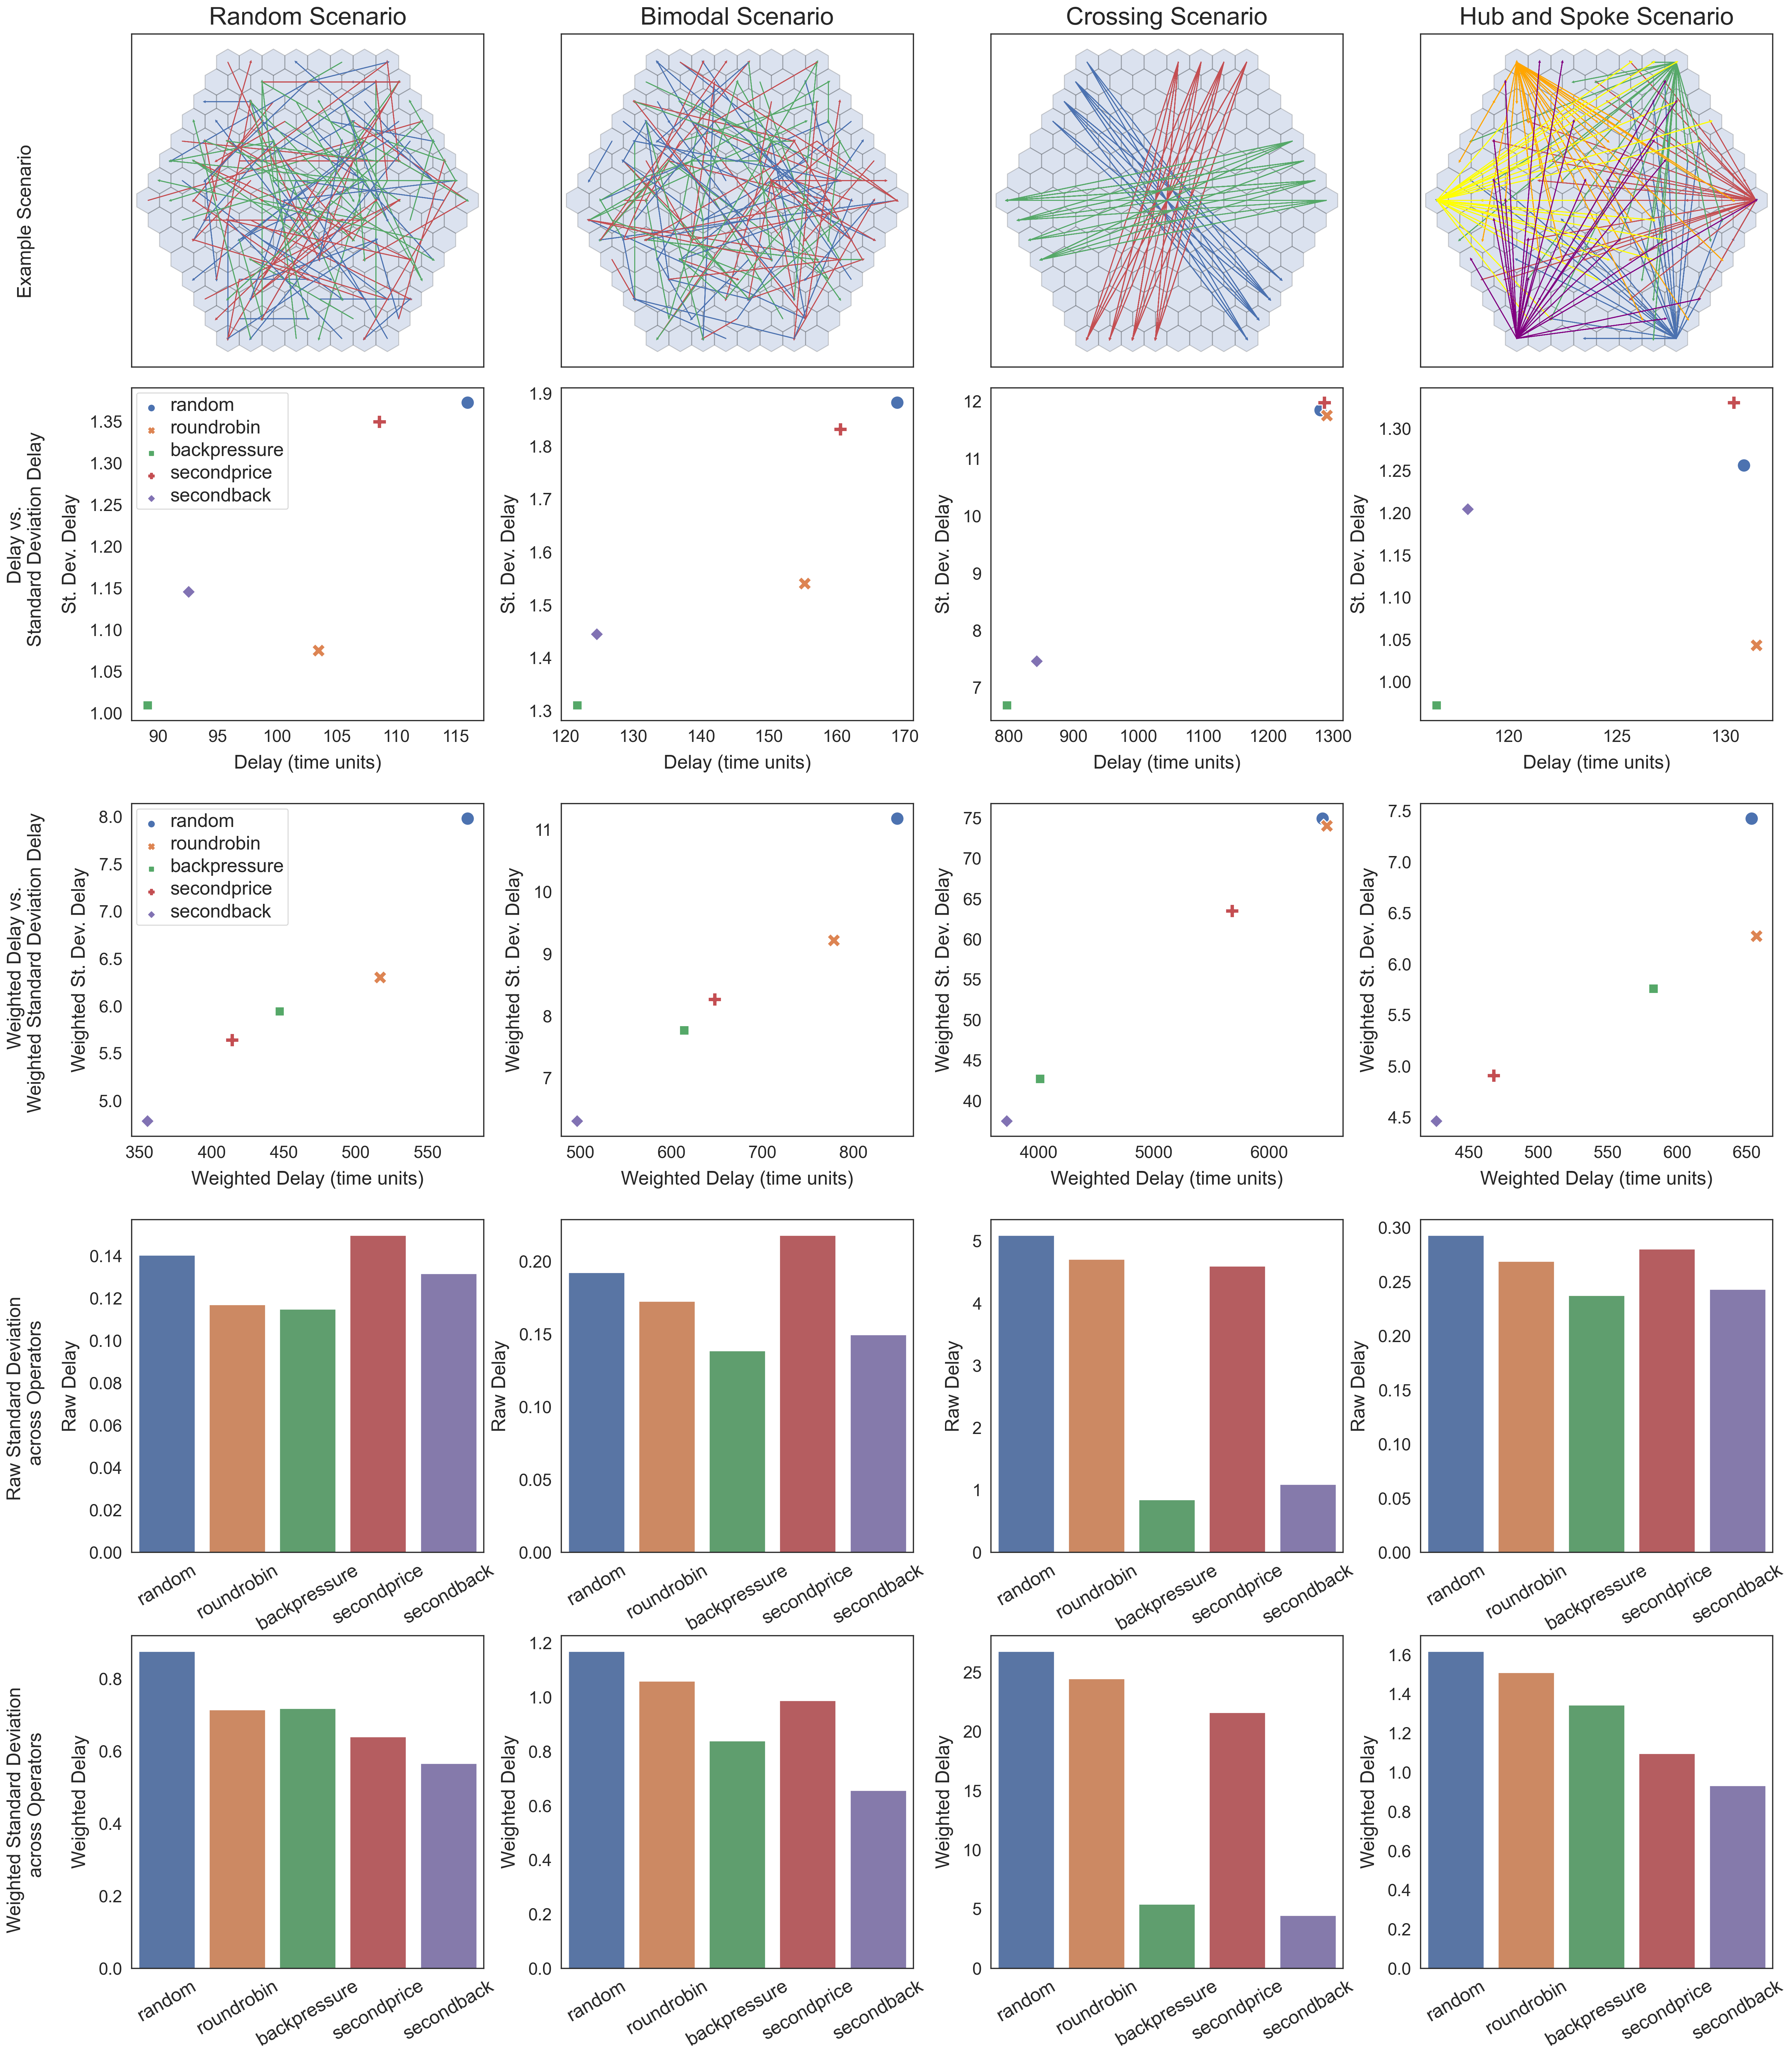

In [320]:
scenes = ["Random Scenario", "Bimodal Scenario", "Crossing Scenario", "Hub and Spoke Scenario"]


parameters = {'axes.labelsize': 16,
          'axes.titlesize': 20}
plt.rcParams.update(parameters)

f, axs = plt.subplots(9, len(scenes), figsize=(7.75 * len(scenes), 7.5 * 5), gridspec_kw=dict(height_ratios=[4, 0.25, 4, 1, 4, 1, 4, 1, 4], width_ratios=[1,1,1,1], wspace = 0.22, hspace = 0), dpi=200)

title = True

# hiding the extra column
# , wspace = 0.2, hspace = 0.25 
# axe = axs[:, 0]
# for ax in axe:
#     ax.set_visible(False)
# plotset = [0, 1, 3, 5, 7]

for i in range(len(outputs)):

    final_plotter(outputs[i], axs[:, i], scenario = scenes[i], title=title)
    title=False

# plt.subplot_tool()
# plt.subplots_adjust(bottom=0.25)
# plt.show()

# plt.tight_layout()


In [302]:
output['example']

(<__main__.Grid at 0x2bf011940>,
 {25: [<__main__.Agent at 0x2bf0113a0>,
  7: [<__main__.Agent at 0x2bf011a90>,
  19: [<__main__.Agent at 0x2bf011520>,
  35: [<__main__.Agent at 0x16abcad00>,
  11: [<__main__.Agent at 0x16abcae20>,
  9: [<__main__.Agent at 0x16abcafd0>,
  18: [<__main__.Agent at 0x16abcac70>,
  34: [<__main__.Agent at 0x16abcac10>, <__main__.Agent at 0x16a7dc910>],
  10: [<__main__.Agent at 0x16abca790>,
  6: [<__main__.Agent at 0x2bf011220>,
  39: [<__main__.Agent at 0x16abca970>,
  26: [<__main__.Agent at 0x16abca640>,
  37: [<__main__.Agent at 0x2c2615af0>,
  17: [<__main__.Agent at 0x14cb72370>],
  12: [<__main__.Agent at 0x2bf011430>,
  15: [<__main__.Agent at 0x2bf011460>,
  32: [<__main__.Agent at 0x2bf011a30>,
  21: [<__main__.Agent at 0x2bf011ac0>,
  16: [<__main__.Agent at 0x2bf0110d0>,
  24: [<__main__.Agent at 0x2bf0113d0>,
  22: [<__main__.Agent at 0x2bf011b80>,
  40: [<__main__.Agent at 0x2bf011580>],
  38: [<__main__.Agent at 0x2bf0116a0>,
  0: [<__main_

[0.8925983619355867, 0.714467348370958, 0.7177679492836032, 0.6401586550811024, 0.5658461826121717]


/var/folders/q7/vjcrj49s2ybbsyt0_mg_pwg80000gn/T/ipykernel_35354/2414263764.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


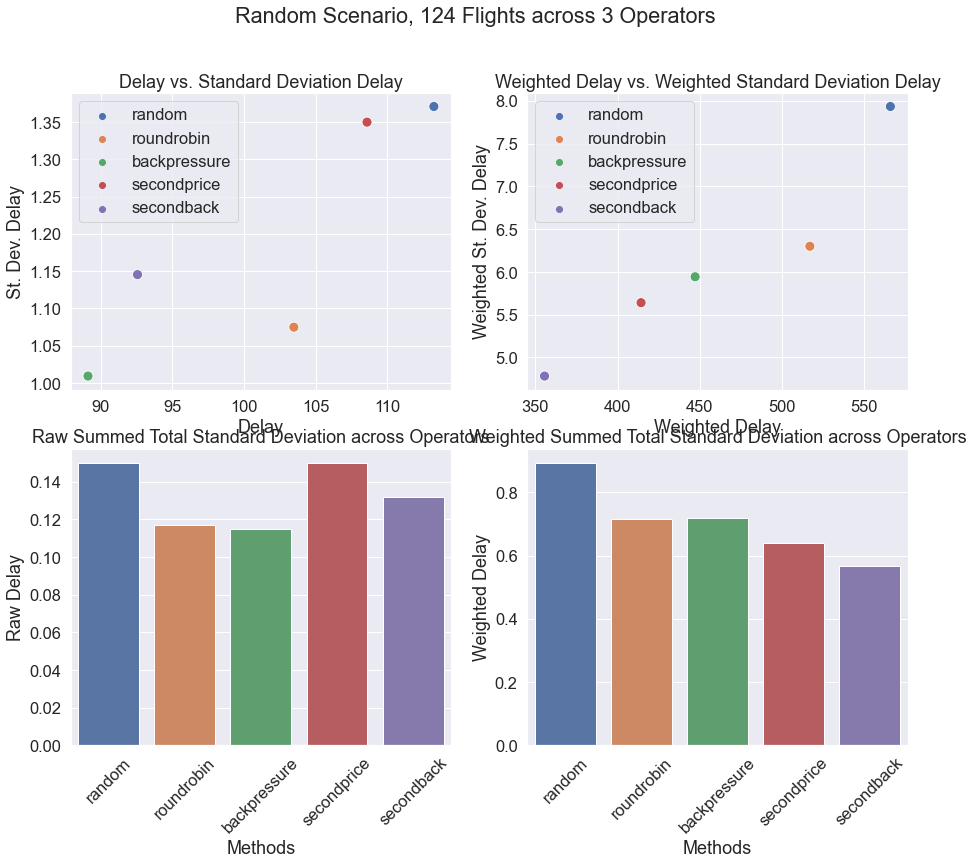

In [243]:
# Quad layout printing 

print(data_avg_operator_diff_wait)


sns.set_theme()
# sns.set(font_scale=1.5)
methods = ["random", "roundrobin", "backpressure", "secondprice", "secondback"]
markers = ['.', 'x', 'o', '+', '*']

f, axs = plt.subplots(2, 2, figsize=(15, 12), gridspec_kw=dict(width_ratios=[1, 1], wspace = 0.2, hspace = 0.2))
sns.scatterplot(x=np.array(data_avg_del), y=data_avg_std, hue=methods, ax=axs[0][0], marker='o', s=100).set(title="Delay vs. Standard Deviation Delay")
sns.scatterplot(x=np.array(data_avg_wait), y=data_avg_std_weighted, hue=methods, ax=axs[0][1], marker='o', s=100).set(title="Weighted Delay vs. Weighted Standard Deviation Delay")

sns.barplot(x = methods, y = data_avg_operator_diff_raw, ax=axs[1][0]).set(title="Raw Summed Total Standard Deviation across Operators")
sns.barplot(x = methods, y = data_avg_operator_diff_wait, ax=axs[1][1]).set(title="Weighted Summed Total Standard Deviation across Operators")

# fig, ax = plt.subplots()
# ax.bar(methods, data_avg_operator_diff_raw)
# ax.set_ylabel("raw delay difference operator")

# fig, ax = plt.subplots()
# ax.bar(methods, data_avg_operator_diff_wait)
# ax.set_ylabel("weighted delay difference operator")



# f.set_axis_labels('Delay', "St. Dev. Delay")



axs[0, 0].set(xlabel= 'Delay', ylabel = "St. Dev. Delay")
axs[0, 1].set(xlabel= 'Weighted Delay', ylabel = "Weighted St. Dev. Delay")
axs[1, 0].set(xlabel= 'Methods', ylabel = 'Raw Delay')
axs[1, 1].set(xlabel= 'Methods', ylabel = 'Weighted Delay')

axs[1,0].tick_params(axis='x', rotation=45)
axs[1,1].tick_params(axis='x', rotation=45)

f.suptitle('Random Scenario, 124 Flights across 3 Operators')



f.tight_layout()

[596.46, 569.78, 555.48, 488.39, 490.4]


[]

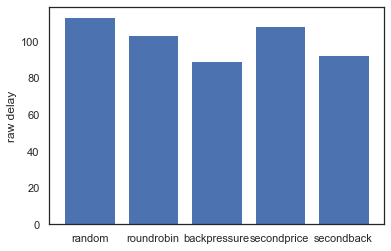

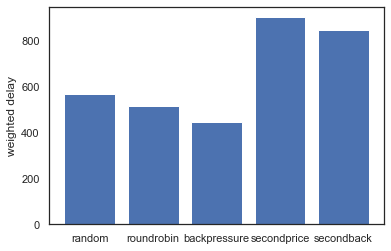

In [241]:
total_pay = np.array(data_avg_wait) + np.array(data_avg_rev)
agent_pay = np.array(data_avg_wait) + np.array(data_avg_pay)

print(data_avg_pay)
temp = np.array(data_avg_pay)
temp[0:3] = 0

fig, ax = plt.subplots()
ax.bar(methods, data_avg_del)
ax.set_ylabel("raw delay")

fig, ax = plt.subplots()
ax.bar(methods, data_avg_wait + temp)
ax.set_ylabel("weighted delay")

plt.plot()

[]

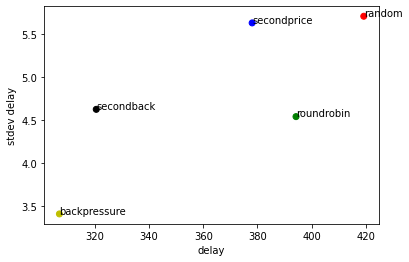

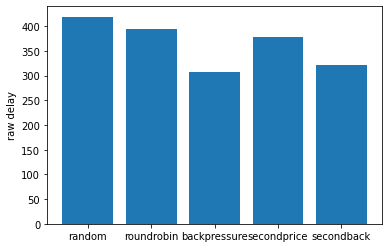

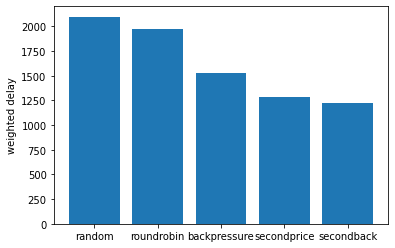

In [15]:
methods = ["random", "roundrobin", "backpressure", "secondprice", "secondback"]

fig, ax = plt.subplots()
ax.scatter(np.array(data_avg_del), data_avg_std, color=["r", "g", "y", "b", "k"])

for i, txt in enumerate(methods):
    ax.annotate(txt, (np.array(data_avg_del)[i], data_avg_std[i]))

ax.set_xlabel("delay")
ax.set_ylabel("stdev delay")

plt.plot()

total_pay = np.array(data_avg_wait) + np.array(data_avg_rev)
agent_pay = np.array(data_avg_wait) + np.array(data_avg_pay)

fig, ax = plt.subplots()
ax.bar(methods, data_avg_del)
ax.set_ylabel("raw delay")

fig, ax = plt.subplots()
ax.bar(methods, data_avg_wait)
ax.set_ylabel("weighted delay")

plt.plot()


Text(0, 0.5, 'stdev weighted delay')

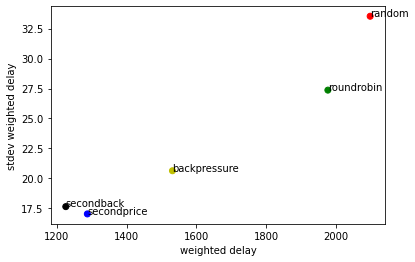

In [16]:
methods = ["random", "roundrobin", "backpressure", "secondprice", "secondback"]

fig, ax = plt.subplots()
ax.scatter(np.array(data_avg_wait), data_avg_std_weighted, color=["r", "g", "y", "b", "k"])

for i, txt in enumerate(methods):
    ax.annotate(txt, (np.array(data_avg_wait)[i], data_avg_std_weighted[i]))

ax.set_xlabel("weighted delay")
ax.set_ylabel("stdev weighted delay")

[0.23326874582730198,
 0.18530138572020205,
 0.15475134141352165,
 0.1763895897353137,
 0.13901746763379927]

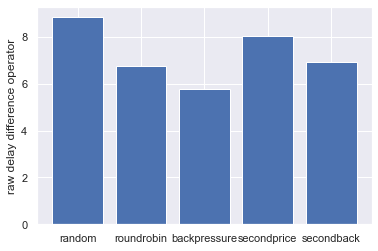

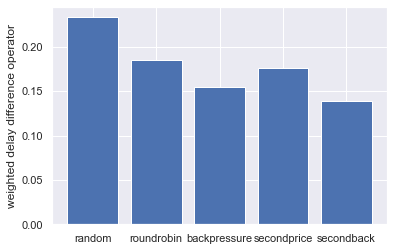

In [34]:
# data_avg_operator_diff_raw
# data_avg_operator_diff_wait

methods = ["random", "roundrobin", "backpressure", "secondprice", "secondback"]

fig, ax = plt.subplots()
ax.bar(methods, data_avg_operator_diff_raw)
ax.set_ylabel("raw delay difference operator")

fig, ax = plt.subplots()
ax.bar(methods, data_avg_operator_diff_wait)
ax.set_ylabel("weighted delay difference operator")

data_avg_operator_diff_wait

In [338]:
def plot_locations_special(layout, coords, active, radius = 5):
    """
    Plot location of agents at the moment. For visualization and debugging
    Inputs:
        layout: Layout object for grid visualization
        coords: list of Hex, coordinates that exists on the grid
        active: list of Agents, all agents active and to be plotted
    Returns:
    """

    sns.set_theme(style="white")

    locations = {}
    for ag in active:
        locations[ag.loc] = (ag._id, ag.finished, ag.bid[0], ag.bid[1])
    
    fig, ax = plt.subplots(1, figsize=(radius * 2, radius * 2), dpi= 2*radius * 25,)

    # ax.set(xlim=(-7, 7), ylim=(-7,7))
    
    for h in coords:

        color = None
        if h in locations.keys():
            if locations[h][1]: color = "Green"
            else: color = "Red"
        
        if h == Hex(0, 0, 0): color = "Green"

        # print(hex_to_pixel(layout, h))
        x, y = hex_to_pixel(layout, h)
        hex = RegularPolygon((x,y), numVertices=6, radius= 1, 
                             orientation=np.radians(0), 
                             facecolor= color, alpha=0.2, edgecolor='k')
        ax.add_patch(hex)
        
        if h in locations.keys() and locations[h][2] is not None:
            x_n, y_n = hex_to_pixel(layout, locations[h][2])
            dx = x_n - x
            dy = y_n - y
            arrow = Arrow(x + dx/4, y + dy/4, dx/2, dy/2, width=0.4)
            ax.add_patch(arrow)
            
        # # Also add a text label
        label = ''
        if h in locations.keys():
            label = str(locations[h][0]) + ',' + str(locations[h][3])
        ax.text(x, y, label if h in locations.keys() else '', ha='center', va='center', fontsize=34)

        

    # Also add scatter points in hexagon centres
    # ax.scatter(hcoord, vcoord, c=[c[0].lower() for c in colors], alpha=0.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.autoscale()
    plt.show()

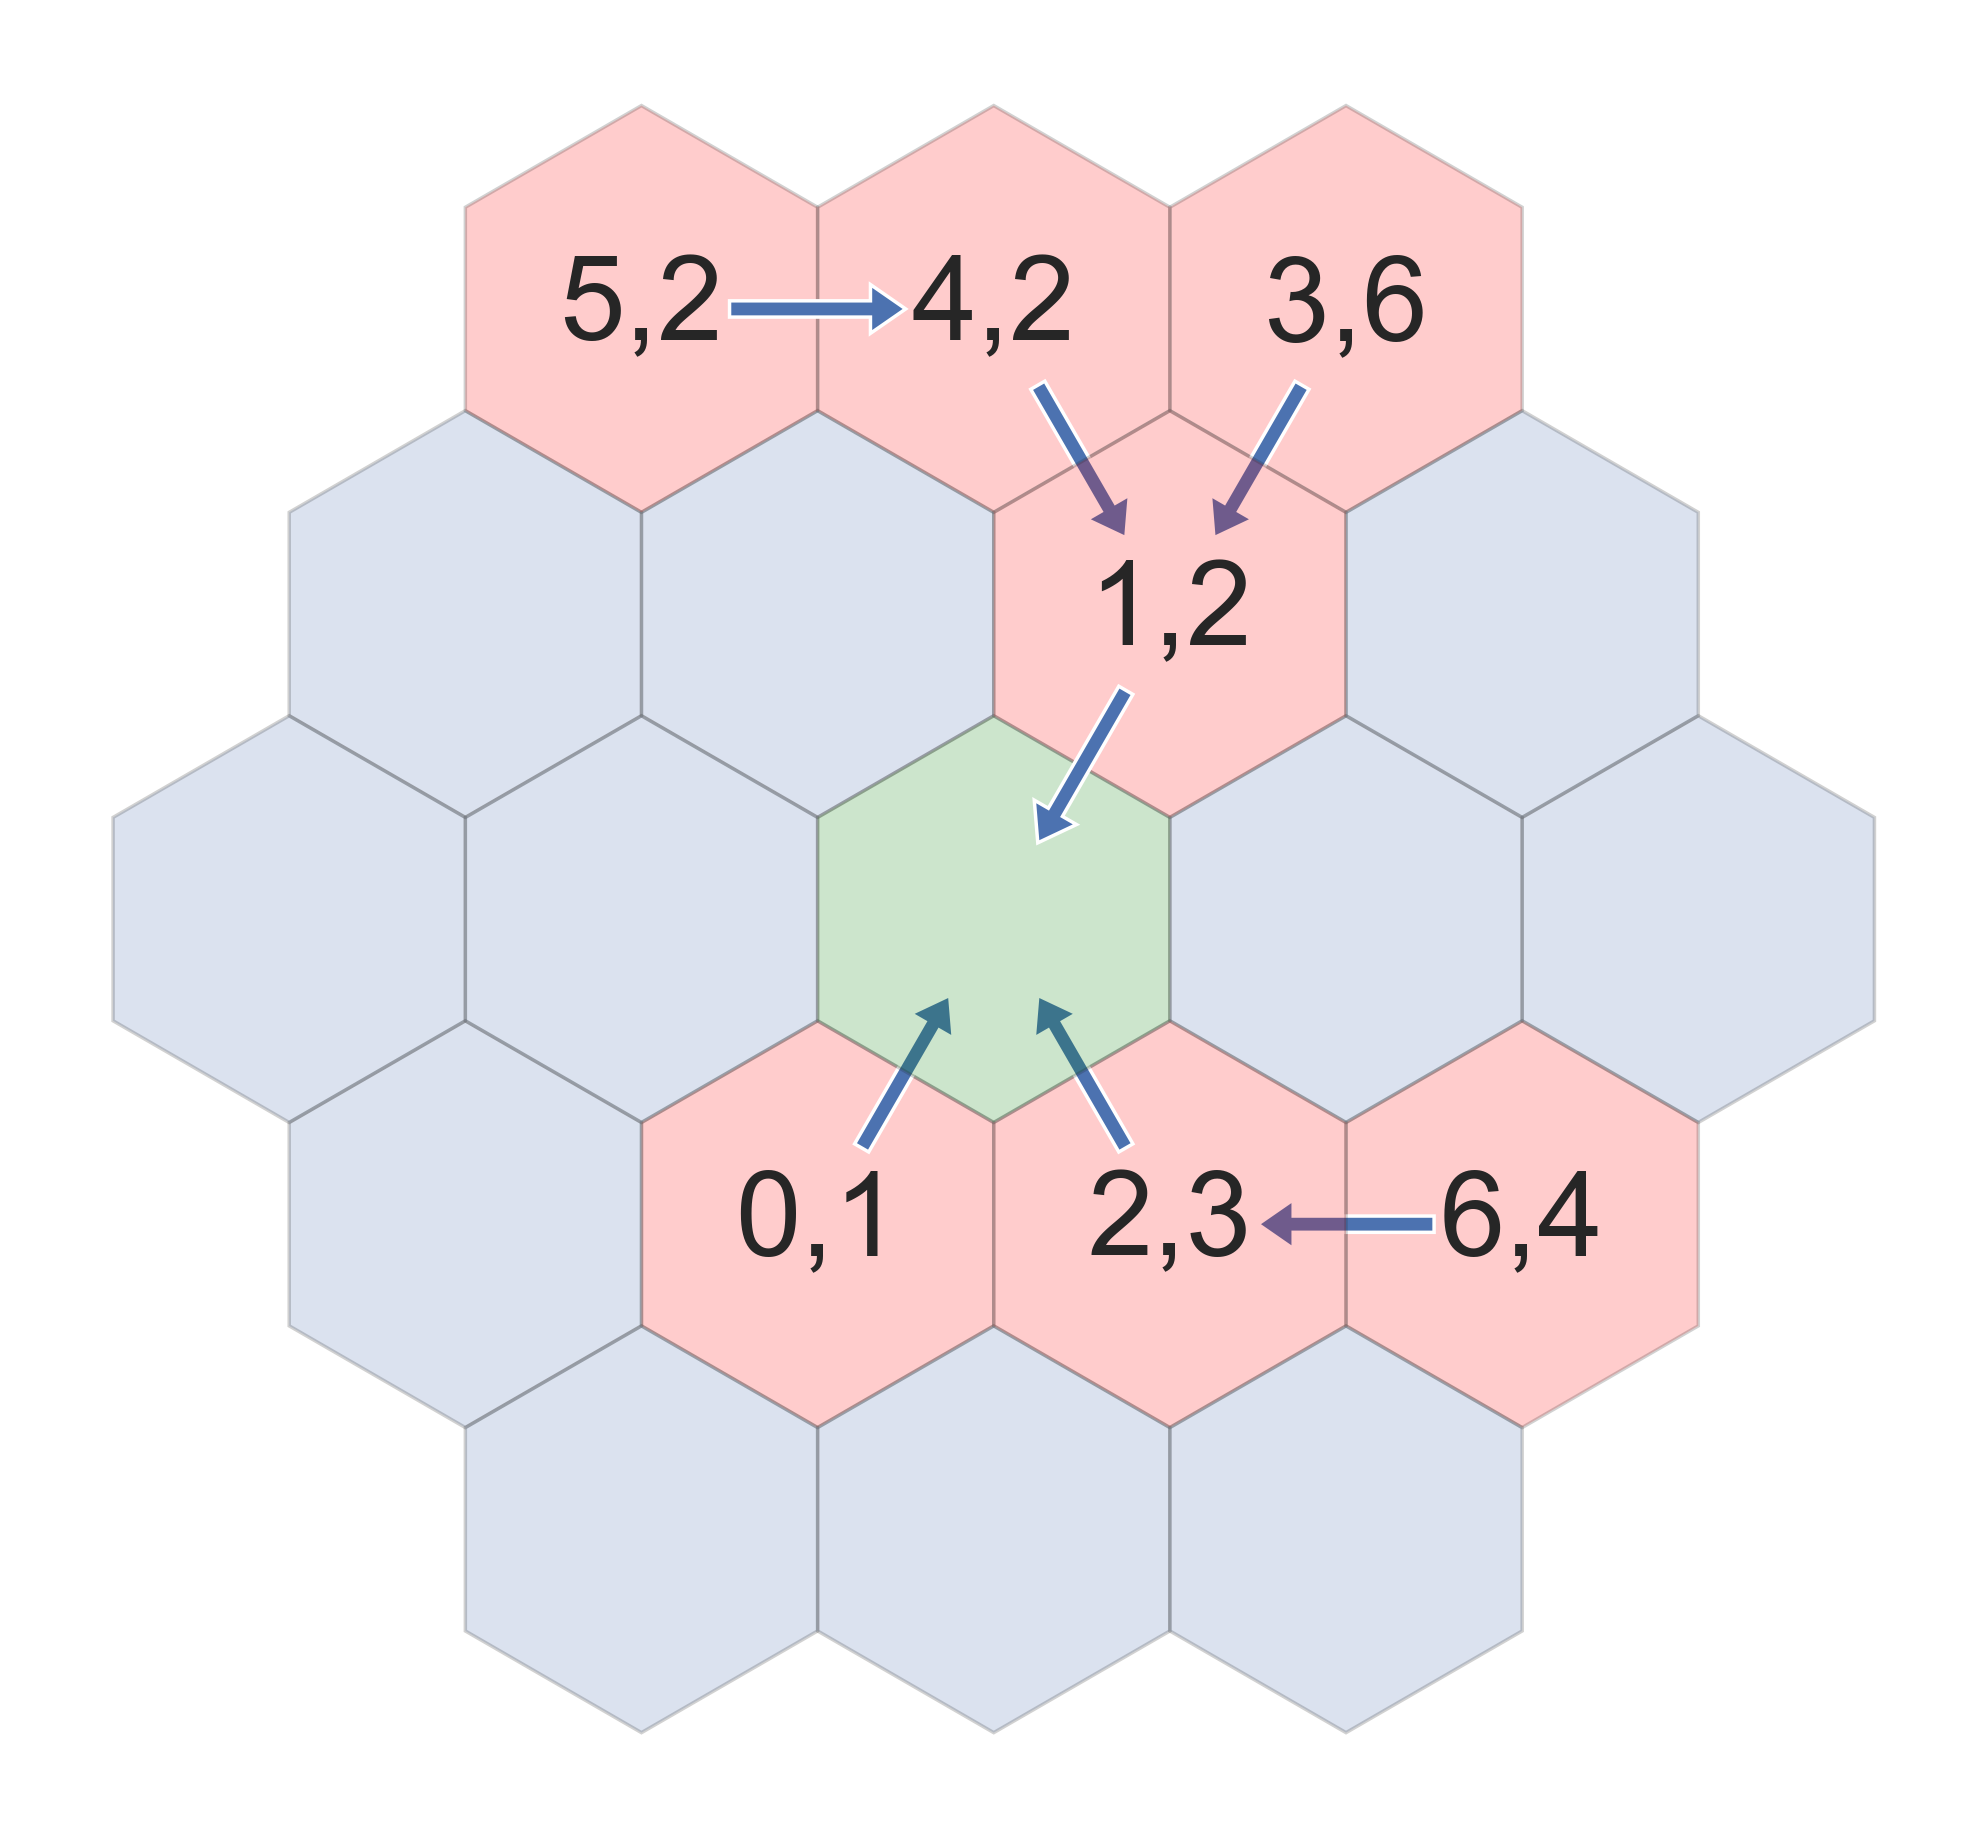

In [339]:
layout = Layout(layout_pointy, Point(1, 1), Point(0, 0))



grid = Grid(2)

agents = []
agents.append(Agent(Hex(0, -1, 1), Hex(0, 0, 0), 1, 0))
agents.append(Agent(Hex(0, 1, -1), Hex(0, 0, 0), 2, 0))
agents.append(Agent(Hex(1, -1, 0), Hex(0, 0, 0), 3, 0))

agents.append(Agent(Hex(0, 2, -2), Hex(0, 0, 0), 6, 0))
agents.append(Agent(Hex(-1, 2, -1), Hex(0, 0, 0), 2, 0))
agents.append(Agent(Hex(-2, 2, 0), Hex(-1, 2, -1), 2, 0))

agents.append(Agent(Hex(2, -1, -1), Hex(0, -1, 1), 4, 0))
# grid, agents, schedule = create_random(num_agents=10, radius = 3)

# agents[1]._loc = Hex(0, -1, 1)
for i, ag in enumerate(agents):
    ag._id = i
    ag.move((ag._steps[ag._index], 0))

plot_locations_special(layout, grid.coords_l, agents)

# locations = {}
# temp = True
# step = [Hex(2, -1, -1), Hex(3, -1, -2)]
# for h in step:
# # for h in agents[3]._steps:
#     locations[h] = (3, temp)
#     temp = False

# temp = True
# for h in agents[16]._steps:
#     locations[h] = (16, temp)
#     temp = Falses

# # temp = True
# # for h in agents[2]._steps:
# #     locations[h] = (2, temp)
# #     temp = False
    
# plot_locations(layout, grid.coords_l, locations)

In [329]:
def plot_locations_trajectories(layout, coords, active, radius = 5):
    """
    Plot location of agents at the moment. For visualization and debugging
    Inputs:
        layout: Layout object for grid visualization
        coords: list of Hex, coordinates that exists on the grid
        active: list of Agents, all agents active and to be plotted
    Returns:
    """

    sns.set_theme(style="white")

    locations = {}
    for ag in active:
        locations[ag.loc] = (ag._id, ag.finished, ag.bid[0], ag.bid[1])
    
    fig, ax = plt.subplots(1, figsize=(radius * 2, radius * 2), dpi= 2*radius * 25)

    # ax.set(xlim=(-7, 7), ylim=(-7,7))
    
    for h in coords:

        # color = None
        # if h in locations.keys():
        #     if locations[h][1]: color = "Green"
        #     else: color = "Red"
        
        # if h == Hex(0, 0, 0): color = "Green"

        # print(hex_to_pixel(layout, h))
        x, y = hex_to_pixel(layout, h)
        hex = RegularPolygon((x,y), numVertices=6, radius= 1, 
                             orientation=np.radians(0), 
                             alpha=0.2, edgecolor='k')
        ax.add_patch(hex)
        
        # if h in locations.keys() and locations[h][2] is not None:
        #     x_n, y_n = hex_to_pixel(layout, locations[h][2])
        #     dx = x_n - x
        #     dy = y_n - y
        #     arrow = Arrow(x + dx/4, y + dy/4, dx/2, dy/2, width=0.25)
        #     ax.add_patch(arrow)
            
        # # # Also add a text label
        # label = ''
        # if h in locations.keys():
        #     label = str(locations[h][0]) + ',' + str(locations[h][3])
        # ax.text(x, y, label if h in locations.keys() else '', ha='center', va='center', fontsize="medium")

    for ag in active:
        x_s, y_s = hex_to_pixel(layout, ag._origin)
        x_d, y_d = hex_to_pixel(layout, ag._dest)


        color = None
        if ag._operator:
            if ag._operator == 1: color = 'b'
            if ag._operator == 2: color = 'r'
            if ag._operator == 3: color = 'g'
            if ag._operator == 4: color = 'orange'
            if ag._operator == 5: color = 'yellow'
            if ag._operator == 6: color = 'purple'

        arrow = FancyArrow(x_s, y_s, x_d - x_s, y_d - y_s, 
                            color = color, 
                            head_width = 0.1, head_length = 0.1)
        ax.add_patch(arrow)

        # ax.plot([x_s, y_s], [x_d, y_d], color='k', linestyle='-', linewidth=2)
        # line = lines.Line2D([x_s, x_d], [y_s, y_d], color = color, lw=0.5)
        # ax.add_line(line)

    # Also add scatter points in hexagon centres
    # ax.scatter(hcoord, vcoord, c=[c[0].lower() for c in colors], alpha=0.5)
    ax.set_aspect('equal')
    ax.autoscale()
    plt.show()

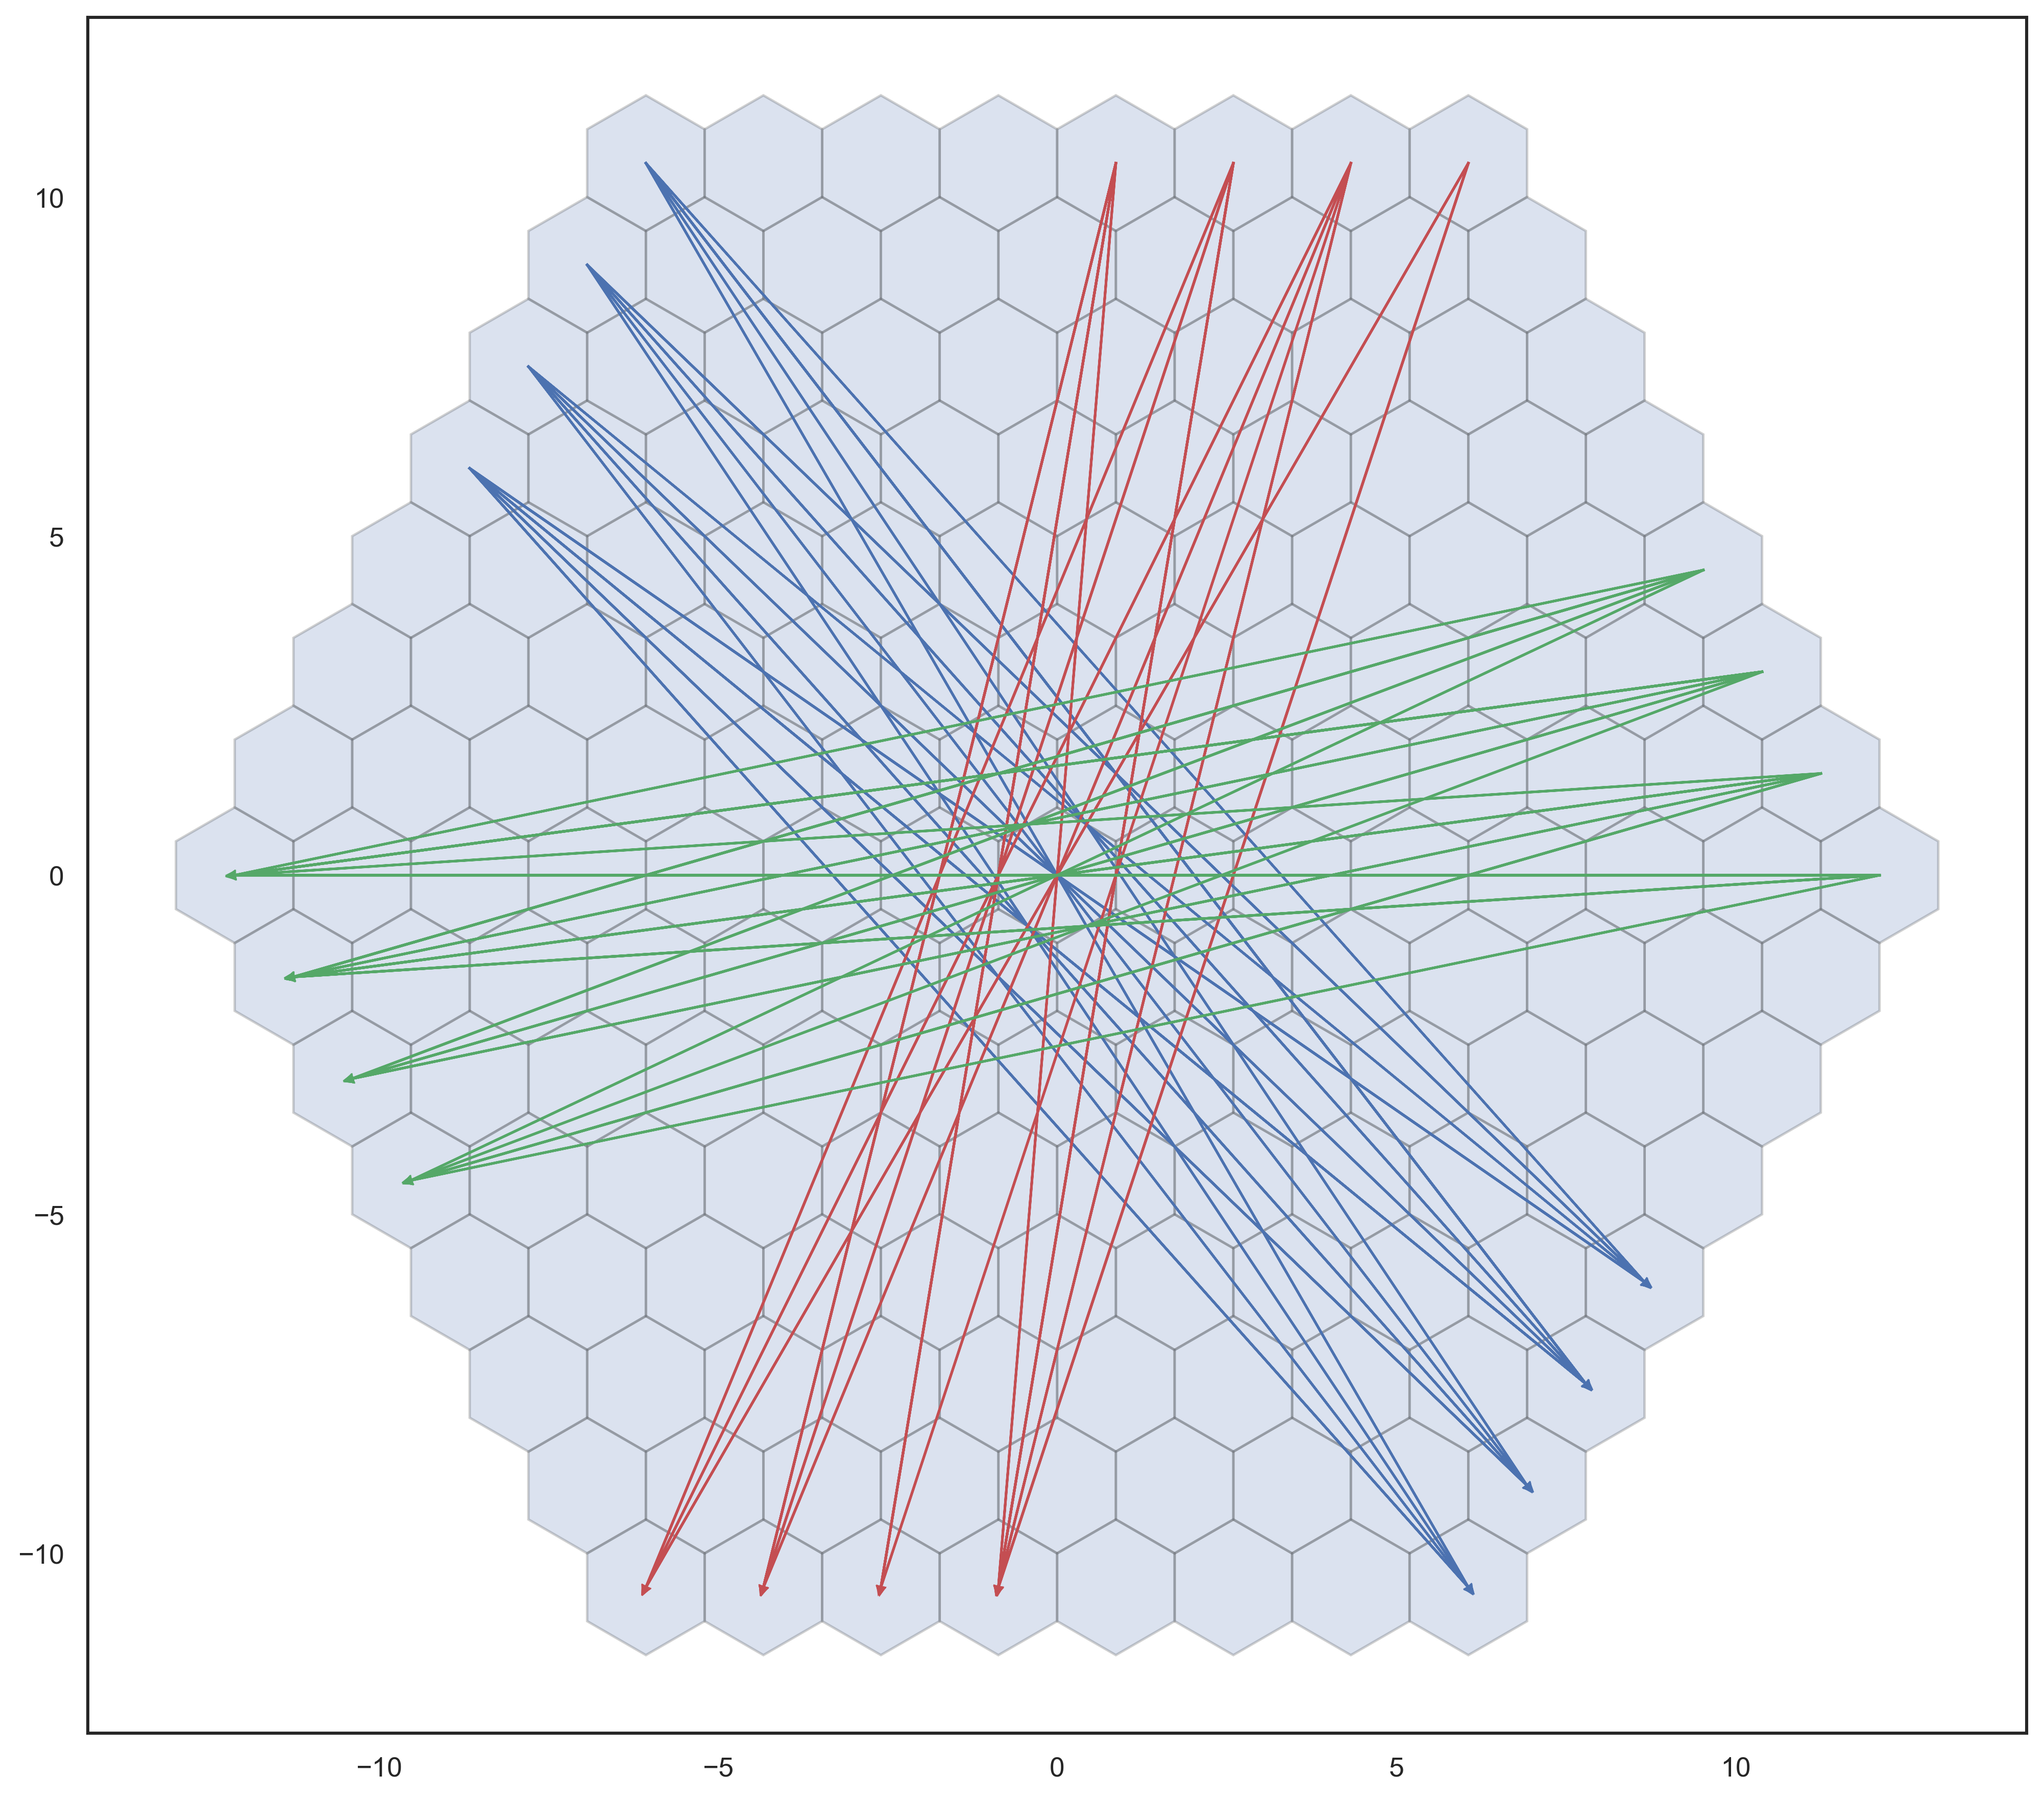

In [233]:
layout = Layout(layout_pointy, Point(1, 1), Point(0, 0))
operator_flag = True
# grid, agents, schedule = create_bimodal(num_agents=126, radius=7, time=50, operator_flag = operator_flag)
# grid, agents, schedule = create_crossing(num_agents = [40,60], radius = 7, time = 50, points = 4)
grid, agents, schedule = create_crossing_2(num_agents = [30,30, 40], radius = 7, time = 50, points = 4)
# grid, agents, schedule = create_random(num_agents=124, radius=7, iters=50, operator_flag=True)
# grid, agents, schedule = create_hubspoke(num_agents = [35,35,35], radius = 7, seed = None)
# grid, agents, schedule = create_hubspoke(num_agents = [25, 25, 25, 25, 25, 25], radius = 7, seed = None)

plot_locations_trajectories(layout, grid.coords_l, agents, radius = 7)